In [1]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt

# for map projection:
import cartopy.crs as ccrs

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, 
                             #combine='by_coords',
                             compat='override')
    return dset

# Location for each mooring: 

- d13: latitude: 81◦24.202’N
       longitude: 31◦13.247’E
- d15: latitude: 81◦24.255’N
       longitude: 31◦13.533’E
- d17: latitude: 81◦24.587’N
       lonitude: 31◦14.506’E
- MB: latitude: 69 N 52.89
      longitude: 011E 11.89
- MW: latitude: 68 N 58.759
      longitude: 013E 16.845 
- MN: latitude: 68 N 56.109
      lonitude: 013E 19.866
- MS: latitude: 68 N 50.128
      longitude: 012E 45.082   
- y1: longitude: 79.37209
      lontitude: 5.57541
- y2: latitude: 80.03876
      longitude: 5.48733
- y3: latitude: 79.44093
      longitude: 5.56333


In [3]:
d15 = open_s3fs('mooring_barents/A-TWAIN_2015-2017_AT200-3_22-118m_ACDP_16640.nc')
d13 = open_s3fs('mooring_barents/A-TWAIN_2013-2015_AT200-2_14-121m_ACDP_16640.nc')
d17 = open_s3fs('mooring_barents/A-TWAIN_2017-2019_AT200-4_20-167m_ACDP_16640.nc')

y1 = open_s3fs('mooring_yermark/Y1.nc')
y2 = open_s3fs('mooring_yermark/Y2.nc')
y3 = open_s3fs('mooring_yermark/Y3.nc')

MB = open_s3fs('mooring_lofoten/PROVOLO_Mooring_MB.nc')
MW = open_s3fs('mooring_lofoten/PROVOLO_Mooring_MW.nc')
MN = open_s3fs('mooring_lofoten/PROVOLO_Mooring_MN.nc')
MS = open_s3fs('mooring_lofoten/PROVOLO_Mooring_MS.nc')

bathym = open_s3fs('bathym.nc')

In [4]:
p_list = [(31.13247,81.24202),(31.13533,81.24255),(31.14506,81.24587)
          ,(011.1189, 69.5289),(013.16845,68.58759),(013.19866,68.56109),(012.45082,68.50128)
          ,(5.57541,79.37209),(5.48733,80.03876),(5.56333,79.44093)]
c_list = ['c', 'orangered', 'g', 'r', 'm', 'y','tab:orange', 'tab:pink', 'limegreen', 'maroon']

In [5]:
'For the mooringsmap to get the depth as approximation for the bathymetry '
ds_rho = xr.open_dataset("https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/density/decav81B0/0.25/woa18_decav81B0_I00_04.nc",
                         decode_times=False
                        ).isel(time=0)

density = ds_rho.I_an.sel(lat=slice(67, 90), lon=slice(-30,35))

depth = density.idxmax(dim="depth", skipna=True)
depth = depth.drop_vars("time")

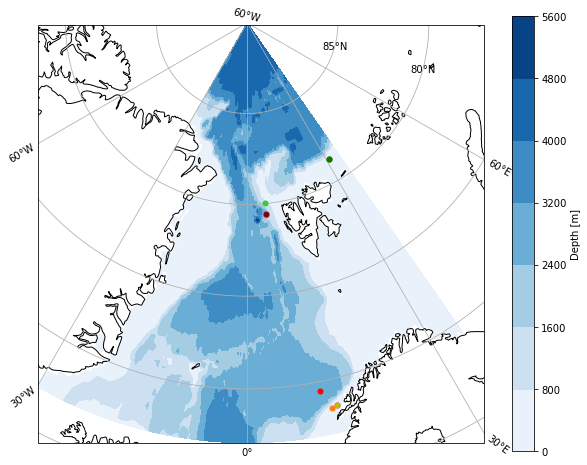

In [6]:
fig, ax = plt.subplots(1, 1,
                       figsize=(10, 8),
                       subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
ax.coastlines()
ax.gridlines(lw=2, ec='black', draw_labels=True)

c = ax.contourf(depth.lon, depth.lat, depth,
                transform=ccrs.PlateCarree(),
                #colors="black",
                #levels=5,
                cmap="Blues"
                )
i = 0
for p in p_list:
    ax.plot(p[0], p[1],
             marker='o', 
             color=c_list[i],
             markersize=5,
             transform=ccrs.PlateCarree(),
             )
    i += 1

fig.colorbar(c,
             shrink=1,
             label=r"Depth [m]"
            )

In [7]:
# Barents sea
u13 = d13.UCUR.fillna(0).squeeze(axis=0)
v13 = d13.VCUR.fillna(0).squeeze(axis=0)
u15 = d15.UCUR.fillna(0).squeeze(axis=0)
v15 = d15.VCUR.fillna(0).squeeze(axis=0)
u17 = d17.UCUR.fillna(0).squeeze(axis=0)
v17 = d17.VCUR.fillna(0).squeeze(axis=0)

# Lofoten
ub = MB.u.fillna(0)
vb = MB.v.fillna(0)
uw = MW.u.fillna(0)
vw = MW.v.fillna(0)
un = MN.u.fillna(0)
vn = MN.v.fillna(0)
us = MS.u.fillna(0)
vs = MS.v.fillna(0)

# Yermark
u1 = y1.u.fillna(0)
v1 = y1.v.fillna(0)
u2 = y2.u.fillna(0)
v2 = y2.v.fillna(0)
u3 = y3.u.fillna(0)
v3 = y3.v.fillna(0)

vel_l = [(u13,v13),(u15,v15), (u17,v17), (ub,vb),(uw,vw),(un,vn),(us,vs),(u1,v1),(u2,v2),(u3,v3)]
depth_l = [()]

In [8]:
def PCz(data):
    cov = np.cov(data.T, bias=True) # uten .T ble den en 73x73 matrise     
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors

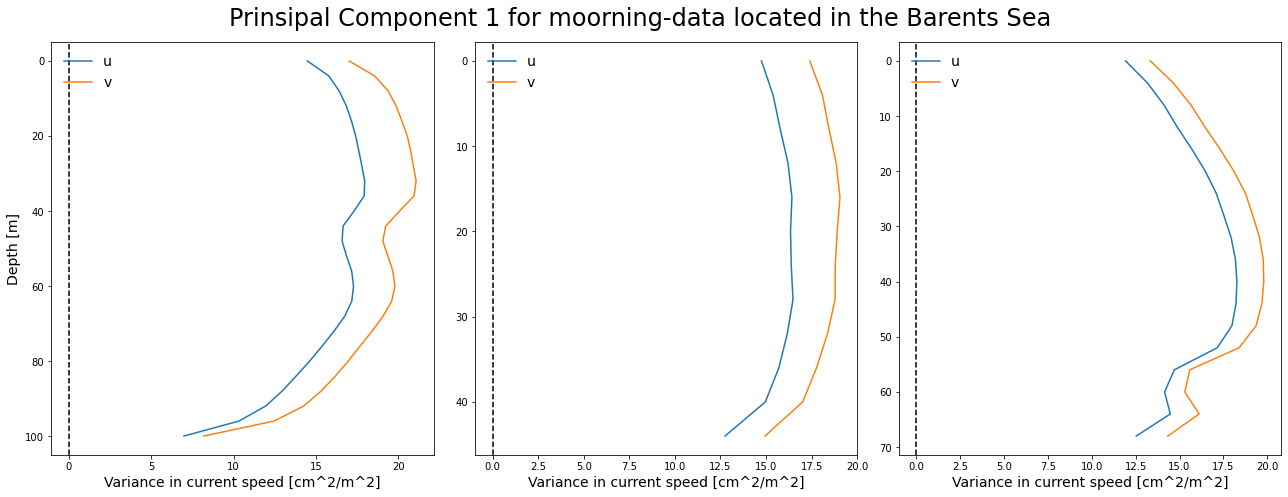

In [9]:
fig, axs = plt.subplots(1,3,figsize=(18,7))
yl = [(u13,v13),(u15,v15),(u17,v17)]
plt.suptitle('Prinsipal Component 1 for moorning-data located in the Barents Sea ', 
             horizontalalignment='center',
            fontsize=24)

axs[0].set_ylabel('Depth [m]', fontsize=14)

for axs, y in zip(axs.flat, yl):
    U =y[0]
    V = y[1]
    valu, vecu = PCz(U)
    valv, vecv = PCz(V)
    axs.plot(np.sqrt(valu[0])*vecu[:,0],U.nDEPTH*4, label= 'u')
    axs.plot(np.sqrt(valv[0])*vecv[:,0],V.nDEPTH*4, label= 'v')
    axs.axvline(0, color='k', linestyle = '--')
    axs.invert_yaxis()
    axs.set_xlabel('Variance in current speed [cm^2/m^2]', fontsize=14)
    axs.legend(frameon=False, fontsize=14, loc="upper left") 
fig.tight_layout()

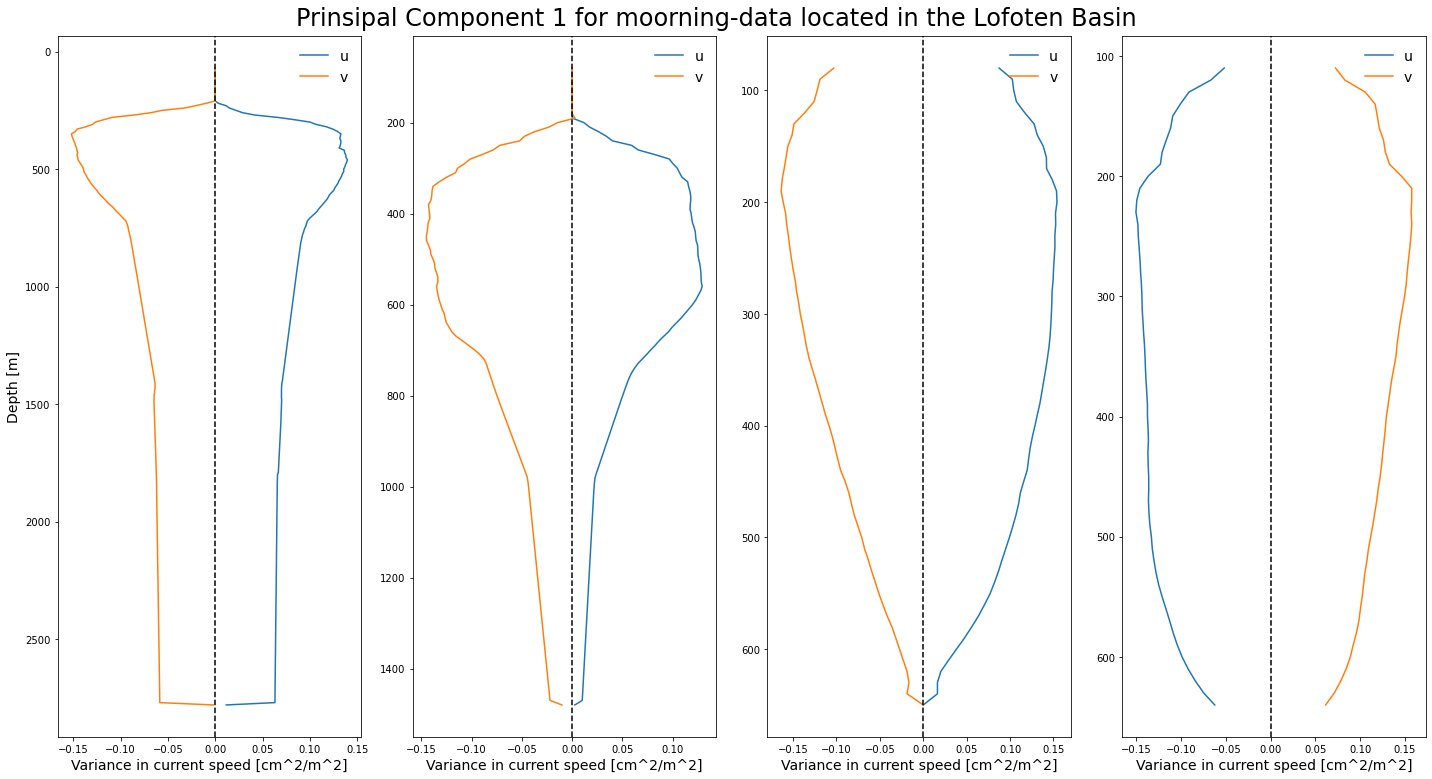

In [10]:
warnings.simplefilter("ignore")
fig, axs = plt.subplots(1,4,figsize=(20,11))
yl = [(ub,vb),(uw,vw),(un,vn),(us,vs)]
plt.suptitle('Prinsipal Component 1 for moorning-data located in the Lofoten Basin', 
             horizontalalignment='center',
            fontsize=24)

axs[0].set_ylabel('Depth [m]', fontsize=14)

for axs, y in zip(axs.flat, yl):
    #for axs, p in zip(axes.flat, range(len((punkt_list)))):
    U =y[0]
    V = y[1]
    valu, vecu = PCz(U)
    valv, vecv = PCz(V)
    axs.plot(np.sqrt(valu[0])*vecu[:,0],U.DEPTH, label= 'u')
    axs.plot(np.sqrt(valv[0])*vecv[:,0],V.DEPTH, label= 'v')
    axs.axvline(0, color='k', linestyle = '--')
    axs.invert_yaxis()
    axs.set_xlabel('Variance in current speed [cm^2/m^2]', fontsize=14)
    axs.legend(frameon=False, fontsize=14, loc="upper right")
fig.tight_layout()

In [11]:
def PCz_yermark(data):
    cov = np.cov(data.isel(DEPTH=slice(3,-1)), bias=True) # uten .T ble den en 73x73 matrise     
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors

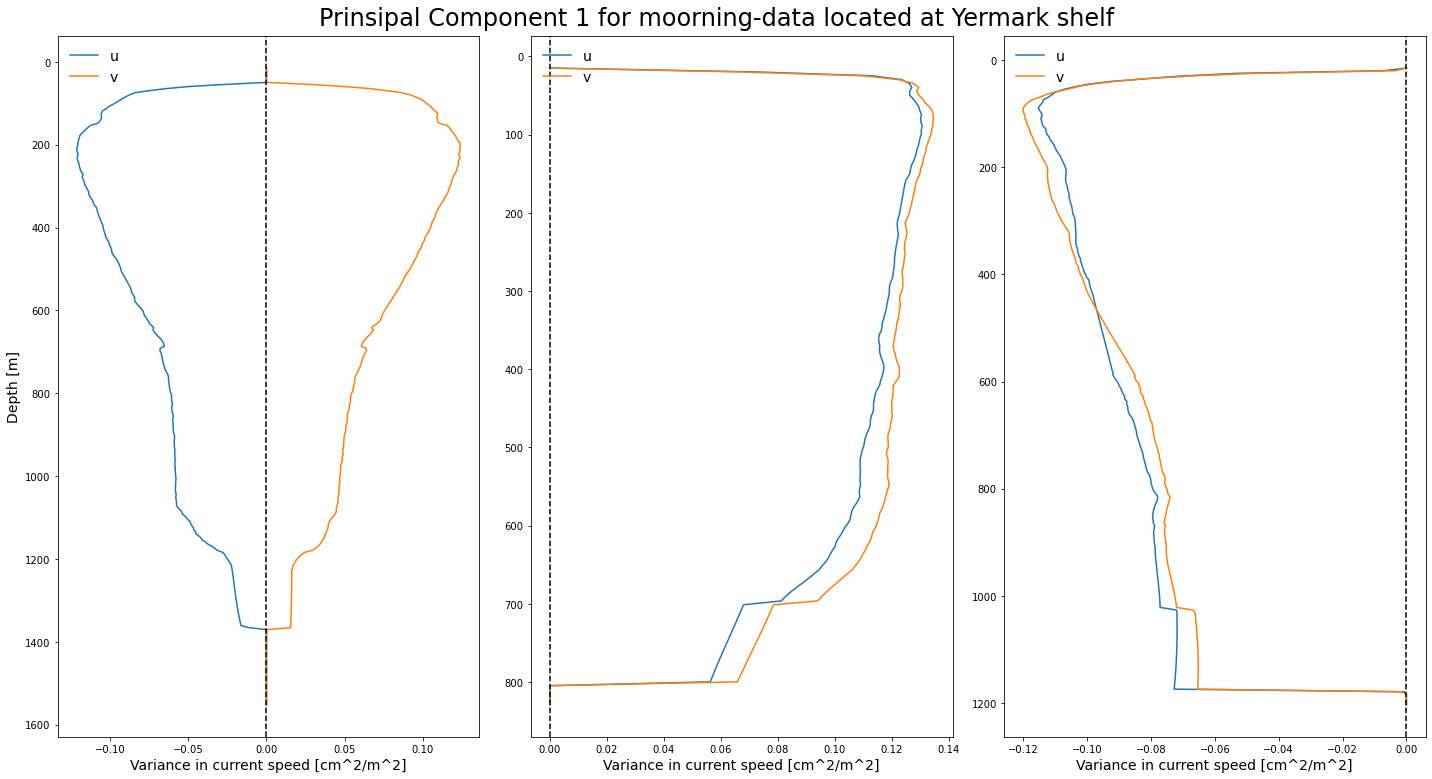

In [12]:
fig, axs = plt.subplots(1,3,figsize=(20,11))
yl = [(u1,v1),(u2,v2),(u3,v3)]
plt.suptitle('Prinsipal Component 1 for moorning-data located at Yermark shelf', 
             horizontalalignment='center',
            fontsize=24)

axs[0].set_ylabel('Depth [m]', fontsize=14)

for axs, y in zip(axs.flat, yl):
    #for axs, p in zip(axes.flat, range(len((punkt_list)))):
    U =y[0]
    V = y[1]
    valu, vecu = PCz_yermark(U)
    valv, vecv = PCz_yermark(V)
    axs.plot(np.sqrt(valu[0])*vecu[:,0],U.DEPTH.isel(DEPTH=slice(3,-1)), label='u')
    axs.plot(np.sqrt(valv[0])*vecv[:,0],V.DEPTH.isel(DEPTH=slice(3,-1)), label='v')
    axs.axvline(0, color='k', linestyle = '--')
    axs.invert_yaxis() 
    axs.set_xlabel('Variance in current speed [cm^2/m^2]', fontsize=14)
    axs.legend(frameon=False, fontsize=14, loc="upper left") 
fig.tight_layout()

## Horizontal variance ellipses at different depths 

Depth looked at from model data:

- [5.05760014e-01 9.82275009e+00 3.08745613e+01 6.90216827e+01 3.33862823e+02 5.08639893e+02 1.51636365e+03 3.13856494e+03]


In [ ]:
def ellipser(u,v,depth):
    uvar = u.isel(DEPTH=depth)**2 - (u.isel(DEPTH=depth).mean())**2
    vvar = v.isel(DEPTH=depth)**2 - (v.isel(DEPTH=depth).mean())**2
    uv = u.isel(DEPTH=depth)**2*v.isel(DEPTH=depth)**2 - u.isel(DEPTH=depth).mean()*v.isel(DEPTH=depth).mean()
    
    cov = np.array([[uvar,uv],
                [uv,vvar]],dtype=float)
    values_, vectors_ = np.linalg.eig(covm)
    order = values_.argsort()[::-1]
    values, vectors = values_[order], vectors_[:, order]

    # ellipser :
    major = np.sqrt(values[0])*scale
    minor = np.sqrt(values[1])*scale
    
    #major_info.append(values[0])

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = vectors[:,0][0], vectors[:,0][1]
    theta = np.arctan2(vy, vx)*(180/math.pi)
   
    return major, minor, theta, x, y

In [ ]:
# Plot level 1
s = 0.5e3 #stands for scale

fig, ax = plt.subplots(1, 1,
                       figsize=(15, 15),
                       subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
plt.title('Horizontal variance ellipses of the current at m depth')
ax.contour(bathym.mbathy.isel(, colors='grey',levels=8, linewidths=0.4)
ax.coastlines()
ax.gridlines(lw=2, ec='black', draw_labels=True)
c = ax.contourf(depth.lon, depth.lat, depth,
                transform=ccrs.PlateCarree(),
                #colors="black",
                #levels=5,
                cmap="Blues"
                )
#i = 0
for vel in vel_l:
    for p in p_list:
       u = vel[0]
       v = vel[1]
       lon = p[0]
       lat = p[1]
       maj_, min_, theta_ = ellipser(u,v,depth)
       ellipse = Ellipse((lon,lat), 
                width = maj_*2, 
                height = min_*2,
                angle = theta_,
                facecolor = 'none',
                edgecolor='k')
       ax.add_patch(ellipse)
       #i += 1

fig.colorbar(c,
             shrink=1,
             label=r"Depth [m]"
            )
    
#PVE = round(((maj_ax[index_max]**2)/s)/(((maj_ax[index_max]**2)/s)+((min_ax[index_max]**2)/s)),2)

ax.set_aspect('equal')
fig.tight_layout()

### Projecting data along bathymetry

In [ ]:
'Making a function for the vertical PC'
def PCz(up,vp):

    zonalp = zonal.isel(y=y, x=x)
    merdp = merd.isel(y=y, x=x)

    d_hbx_p = d_hbxg.isel(y=y, x=x)
    d_hby_p = d_hbyg.isel(y=y, x=x)
    
    # lag lengde scalar av bathym og dele u_o og u_p på 

    vel_ort = (up*(d_hbx_p/zonalp) + vp*(d_hby_p/merdp))/np.sqrt(d_hbx_p**2 + d_hby_p**2) # delt på lengden av bathymetrien
    vel_par = (up*(d_hby_p/merdp)  - vp*(d_hbx_p/zonalp))/np.sqrt(d_hbx_p**2 + d_hby_p**2)
    
    d_p = d.isel(y=y, x=x).values
    dyp_o = vel_ort.isel(depth = slice(12,int(d_p)-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dyp_p = vel_par.isel(depth = slice(12,int(d_p)-1))

    cov_o = np.cov(dyp_o.T, bias=True) # uten .T ble den en 73x73 matrise 
    cov_p = np.cov(dyp_p.T, bias=True)
    
    values_o, vectors_o = np.linalg.eig(cov_o)
    order_o = values_o.argsort()[::-1]
    values_o, vectors_o = values_o[order_o], vectors_o[:, order_o]
    values_p, vectors_p = np.linalg.eig(cov_p)
    order_p = values_p.argsort()[::-1]
    values_p, vectors_p = values_p[order_p], vectors_p[:, order_p]
    
    PCp = np.sqrt(values_p[0])*vectors_p[:,0]
    PCo = np.sqrt(values_o[0])*vectors_o[:,0]
    
    return PCp, PCo, dyp_p, dyp_o